In [1]:
!pip install watermark



In [2]:
# Importing Necessary libraries
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from numba import njit
from tqdm import trange
from sklearn.base import BaseEstimator, ClassifierMixin

%watermark -a 'Ethen' -d -t -v -p numba,numpy,pandas,sklearn,matplotlib

Ethen 2020-09-12 04:39:43 

CPython 3.6.9
IPython 5.5.0

numba 0.48.0
numpy 1.18.5
pandas 1.0.5
sklearn 0.0
matplotlib 3.2.2


In [3]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving hotel_data_clean.csv to hotel_data_clean.csv


In [4]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['hotel_data_clean.csv']))

In [5]:
# Print Multiple statements in same line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [6]:
#Explore Data
data.shape
type(data)
data.size
data.shape
data.head()
data.tail()
data.info()

(24180, 11)

pandas.core.frame.DataFrame

265980

(24180, 11)

,Index,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,User_id
0,0,0,La Quinta,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,hotel dump upon checking told place booked fol...,1.0,"['hotel', 'dump', 'upon', 'checking', 'told', ...",Negative,15400
1,1,1,The Point,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,stayed point five days back june 2011 wife ele...,5.0,"['stayed', 'point', 'five', 'days', 'back', 'j...",Positive,3702
2,2,1,The Point,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,point exceeds perfection moment arrive prepare...,5.0,"['point', 'exceeds', 'perfection', 'moment', '...",Positive,3738
3,3,1,The Point,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,review long overdue tell many people place fel...,5.0,"['review', 'long', 'overdue', 'tell', 'many', ...",Positive,4593
4,4,1,The Point,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,picked airport car vacuum cleaned long time mi...,2.0,"['picked', 'airport', 'car', 'vacuum', 'cleane...",Negative,4657


,Index,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,User_id
24175,24175,3128,Polynesian Plaza,Unprofessional,Sharon T,I booked this hotel for mid October months ago...,booked hotel mid october months ago early octo...,1.0,"['booked', 'hotel', 'mid', 'october', 'months'...",Negative,10476
24176,24176,3128,Polynesian Plaza,worst ever !,Shaun F,"We had a one night stay at your hotel, Sept. 1...",one night stay hotel sept 19 2015 worst hotel ...,1.0,"['one', 'night', 'stay', 'hotel', 'sept', '19'...",Negative,10490
24177,24177,3128,Polynesian Plaza,Location!,Steph K,"Positives: Location! It is on the main strip, ...",positives location main strip next hard rock c...,3.0,"['positives', 'location', 'main', 'strip', 'ne...",Negative,10799
24178,24178,3128,Polynesian Plaza,"Polynesian Plaza, Honolulu",Vernon G,Not exactly a five-star hotel but right in the...,exactly fivestar hotel right heart waikiki sho...,4.0,"['exactly', 'fivestar', 'hotel', 'right', 'hea...",Positive,11901
24179,24179,3128,Polynesian Plaza,IN SEVERE NEED OF UPDATE - OVERHAUL,fordpipefitter,We spent 2 weeks in this hotel due to the cost...,spent 2 weeks hotel due cost normal hotels sta...,2.0,"['spent', '2', 'weeks', 'hotel', 'due', 'cost'...",Negative,13911


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24180 entries, 0 to 24179
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index       24180 non-null  int64  
 1   Hotel_id    24180 non-null  int64  
 2   Hotel       24180 non-null  object 
 3   Title       24119 non-null  object 
 4   Users       24180 non-null  object 
 5   Reviews     24179 non-null  object 
 6   Text_Clean  24177 non-null  object 
 7   Rating      24151 non-null  float64
 8   tokens      24180 non-null  object 
 9   Sentiment   24180 non-null  object 
 10  User_id     24180 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 2.0+ MB


In [7]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

In [8]:
data.head()

,Index,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,User_id
0,0,0,La Quinta,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,hotel dump upon checking told place booked fol...,1.0,"['hotel', 'dump', 'upon', 'checking', 'told', ...",0,15400
1,1,1,The Point,How to Feel like you are truly Royalty!,DrThought,After having stayed at The Point for five days...,stayed point five days back june 2011 wife ele...,5.0,"['stayed', 'point', 'five', 'days', 'back', 'j...",1,3702
2,2,1,The Point,Not to be missed,Dushi110,The Point exceeds perfection. From the moment ...,point exceeds perfection moment arrive prepare...,5.0,"['point', 'exceeds', 'perfection', 'moment', '...",1,3738
3,3,1,The Point,The most amazing place....,GracieLouNY,My review is long overdue but I tell so many p...,review long overdue tell many people place fel...,5.0,"['review', 'long', 'overdue', 'tell', 'many', ...",1,4593
4,4,1,The Point,Lack of maintenance,Guillen,We were picked up from the airport in a car wh...,picked airport car vacuum cleaned long time mi...,2.0,"['picked', 'airport', 'car', 'vacuum', 'cleane...",0,4657


In [10]:
# Checking for missing values
pd.isnull(data).any()
pd.isnull(data).sum()

Index         False
Hotel_id      False
Hotel         False
Title          True
Users         False
Reviews        True
Text_Clean     True
Rating         True
tokens        False
Sentiment     False
User_id       False
dtype: bool

Index          0
Hotel_id       0
Hotel          0
Title         61
Users          0
Reviews        1
Text_Clean     3
Rating        29
tokens         0
Sentiment      0
User_id        0
dtype: int64

In [11]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (24116, 11)
Index(['Index', 'Hotel_id', 'Hotel', 'Title', 'Users', 'Reviews', 'Text_Clean',
       'Rating', 'tokens', 'Sentiment', 'User_id'],
      dtype='object')
No. of unique classes 2


In [12]:
# Deriving the feature and the label
X = data['Text_Clean']
y = data['Sentiment'].values

In [13]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1)

In [14]:
# convert both sets' text column to document-term matrix;
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5)
X_train_dtm = tfidf.fit_transform(X_train)
X_test_dtm = tfidf.transform(X_test)
X_train_dtm

<19292x15393 sparse matrix of type '<class 'numpy.float64'>'
	with 690178 stored elements in Compressed Sparse Row format>

In [15]:
class FactorizationMachineClassifier(BaseEstimator, ClassifierMixin):
    """
    Factorization Machine [1]_ using Stochastic Gradient Descent.
    For binary classification only.

    Parameters
    ----------
    n_iter : int, default 10
        Number of iterations to train the algorithm.

    n_factors : int, default 10
        Number/dimension of features' latent factors.

    learning_rate : float, default 0.1
        Learning rate for the gradient descent optimizer.

    reg_coef : float, default 0.01
        Regularization strength for weights/coefficients.

    reg_factors : float, default 0.01
        Regularization strength for features' latent factors.

    random_state : int, default 1234
        Seed for the randomly initialized features latent factors

    verbose : bool, default True
        Whether to print progress bar while training.

    Attributes
    ----------
    intercept_ : double
        Intercept term, w0 based on the original notations.

    coef_ : 1d ndarray, shape [n_features,]
        Coefficients, w based on the original notations.

    feature_factors_ : 2d ndarray, shape [n_factors, n_features]
        Latent factors for all features. v based on the original
        notations. The learned factors can be viewed as the
        embeddings for each features. If a pair of features tends
        to co-occur often, then their embeddings should be
        close/similar (in terms of cosine similarity) to each other.

    history_ : list
        Loss function's history at each iteration, useful
        for evaluating whether the algorithm converged or not.

    References
    ----------
    .. [1] `S. Rendle Factorization Machines (2010)
            <http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf>`_ 
    """

    def __init__(self, n_iter = 10, n_factors = 10,
                 learning_rate = 0.1, reg_coef = 0.01,
                 reg_factors = 0.01, random_state = 1234, verbose = False):
        self.n_iter = n_iter
        self.verbose = verbose
        self.reg_coef = reg_coef
        self.n_factors = n_factors
        self.reg_factors = reg_factors
        self.random_state = random_state
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the model to the input data and label.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        y : 1d ndarray, shape [n_samples,]
            Training data's corresponding label.

        Returns
        -------
        self
        """

        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0

        # the factors are often initialized with a mean of 0 and standard deviation
        # of 1 / sqrt(number of latent factor specified)
        np.random.seed(self.random_state)
        self.feature_factors_ = np.random.normal(
            scale = 1 / np.sqrt(self.n_factors), size = (self.n_factors, n_features))
        
        # the gradient is implemented in a way that requires
        # the negative class to be labeled as -1 instead of 0
        y = y.copy().astype(np.int32)
        y[y == 0] = -1

        loop = range(self.n_iter)
        if self.verbose:
            loop = trange(self.n_iter)

        self.history_ = []
        for _ in loop:
            loss = _sgd_update(X.data, X.indptr, X.indices,
                               y, n_samples, n_features,
                               self.intercept_, self.coef_,
                               self.feature_factors_, self.n_factors,
                               self.learning_rate, self.reg_coef, self.reg_factors)
            self.history_.append(loss)

        return self

    def predict_proba(self, X):
        """
        Probability estimates. The returned estimates for
        all classes are ordered by the label of classes.

        Paramters
        ---------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        proba : 2d ndarray, shape [n_samples, n_classes]
            The probability of the sample for each class in the model.
        """
        pred = self._predict(X)
        pred_proba = 1.0 / (1.0 + np.exp(-pred))
        proba = np.vstack((1 - pred_proba, pred_proba)).T
        return proba

    def _predict(self, X):
        """Similar to _predict_instance but vectorized for all samples"""
        linear_output = X * self.coef_
        v = self.feature_factors_.T
        term = (X * v) ** 2 - (X.power(2) * (v ** 2))
        factor_output = 0.5 * np.sum(term, axis = 1)
        return self.intercept_ + linear_output + factor_output

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters
        ----------
        X : scipy sparse csr_matrix, shape [n_samples, n_features]
            Data in sparse matrix format.

        Returns
        -------
        Predicted class label per sample.
        """
        pred_proba = self.predict_proba(X)[:, 1]
        return pred_proba.round().astype(np.int)


@njit
def _sgd_update(data, indptr, indices, y, n_samples, n_features,
                w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
    Compute the loss of the current iteration and update
    gradients accordingly.
    """
    loss = 0.0
    for i in range(n_samples):
        pred, summed = _predict_instance(data, indptr, indices, w0, w, v, n_factors, i)
        
        # calculate loss and its gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)
    
        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * (v_gradient + 2 * reg_v * v[factor, feature])
    
    loss /= n_samples
    return loss


@njit
def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
    
    # summed is the independent term that can be re-used
    # during the gradient update stage
    return pred, summed


@njit
def _log_loss(pred, y):
    """
    negative log likelihood of the
    current prediction and label, y.
    """
    return np.log(np.exp(-pred * y) + 1.0)

In [16]:
fm = FactorizationMachineClassifier(n_iter = 30, learning_rate = 0.1)
fm.fit(X_train_dtm, y_train)

FactorizationMachineClassifier(learning_rate=0.1, n_factors=10, n_iter=30,
                               random_state=1234, reg_coef=0.01,
                               reg_factors=0.01, verbose=False)

Text(0.5, 1.0, 'Loss Curve Per Iteration')

Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

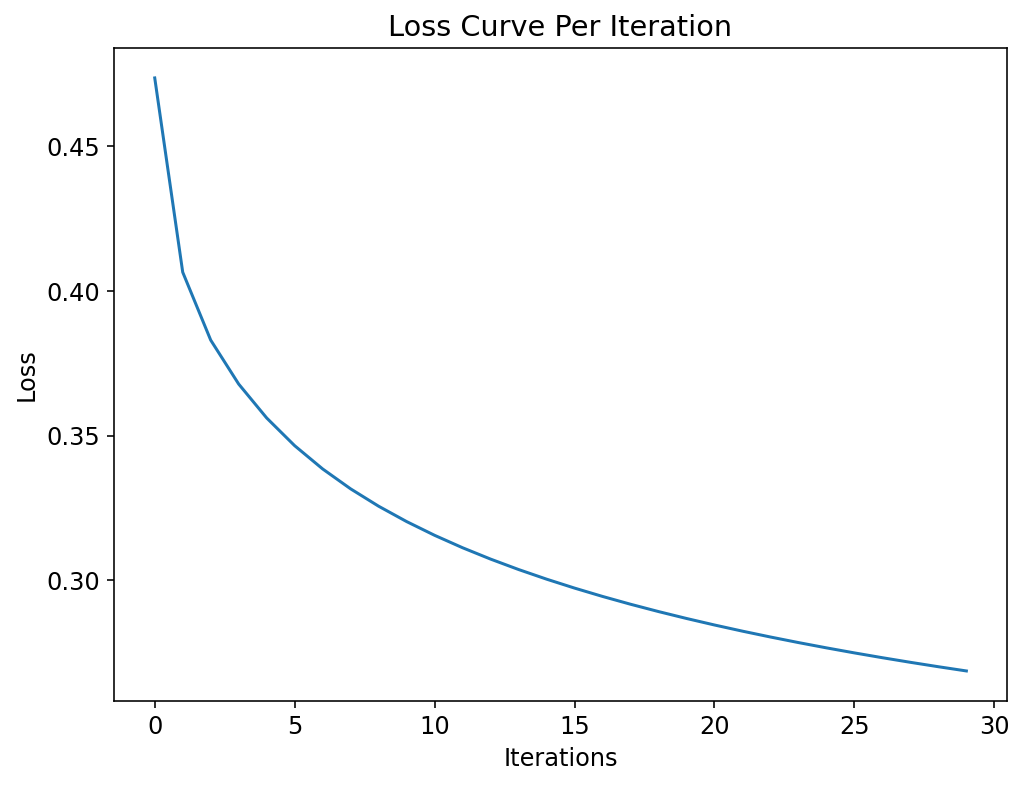

In [17]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# one quick way to check that we've implemented
# the gradient descent is to ensure that the loss
# curve is steadily decreasing
plt.plot(fm.history_)
plt.title('Loss Curve Per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [18]:
# predict on the test set and output the auc score
y_pred_prob = fm.predict_proba(X_test_dtm)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

auc 0.9031289448610893


In [19]:
# we can compare it with a logistic regression,
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

auc 0.9171643664889891
